# runalyze2video
```markdown
Autor:          Maik 'Schrottie' Bischoff
Beschreibung:   Erzeugen von (vertikalen) Statistikvideos aus Daten von runalyze.com.
Version:        1.09
Stand:          16.05.2024
```

### Importe

In [90]:
# -*- encoding: utf-8 -*-
import argparse
import requests
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from moviepy.editor import *
import numpy as np
import pandas as pd
from moviepy.config import change_settings
from moviepy.editor import VideoFileClip, AudioFileClip, concatenate_audioclips
from moviepy.audio.fx.all import audio_fadein, audio_fadeout
import cv2
import shutil
from dateutil.relativedelta import relativedelta
import os
from dotenv import load_dotenv
import re
import sqlite3
from PIL import Image, ImageDraw, ImageFont
import calendar
import sys
import logging
import locale
from IPython.display import clear_output
from r2v_functions import *

locale.setlocale(locale.LC_ALL, 'de_DE.UTF-8') # Setzen des Gebietsschemas auf Deutsch

'de_DE.UTF-8'

### ToDo/Wishlist

- Der Aktivitätstitel muss noch rein, allerdings gibt es da das Problem mit Unicode-Symbolen. Die müssten rausfliegen, dann Umlaute korrigieren und den Titel bei den Einzelaktivitäten mit rein. **Issue #26 und #27**
- Die Schriftbreite für die Aktivitätstitel muss berechnet werden, damit längere Titel einen Umbruch bekommen. Möglicherweise wäre hier matplotlip geeigneter als cv2. **Issue #15**

### Globale Variablen und andere Einstellungen

In [91]:
global run_mode
global sportid
global background_sound
global start_date_string
global end_date_string
global max_download_frequency
global duration_per_row
global internal_id

# Falls ImageMagick nicht installiert werden kann, einfach eine portable Version
# herunterladen und hier den Pfad angeben
#change_settings({"IMAGEMAGICK_BINARY": r"D:\Imagemagick\convert.exe"})

# Diverse Variablen
chart_file_pic = 'tmp/chart.png' # Temporäres Datendiagramm
cloud_pic = 'tmp/cloud.png' # Temporäre Aktivitätstitelgrafik
save_chart = True # Soll das Diagramm gespeichert werden?
csv_file = 'tmp/activities.csv' # Name der heruntergeladenen Daten
db_filename = 'runalyze_data.db' # Name der zu verwendenden SQLite-Datenbank
empty_sample_db = 'stuff/runalyze_data_empty.db' # Leere Beispieldatenbank, für den allerersten Lauf
table_name = 'all_data' # Name der Datentabelle
warnings_table = 'warnings' # Tabelle, in die Python-Warnungen geschrieben werden
log_level = 30 # Mindeststufe der zu loggenden Meldungen: 10 = Deubug, 20 = Info, 30 = Warnung, 40 = Fehler, 50 = Kritisch
weeks_to_keep = 6 # Anzahl der Wochen, für die Protokolleinträge in der datenbank aufgehoben werden sollen

# Video
fade_duration = 1  # Dauer des Überganges in sec
intro_clip_duration = 4 # Anzeigedauer des Introbildes in sec
max_duration_per_row = 3  # Maximaldauer der Anzeige einzelner Aktivitäten im Video in sec
final_duration = 7  # Dauer der Anzeige der Gesamtdaten in sec
outro_clip_duration = 3 # Dauer eines (optionalen) Outro
max_video_length = 60 # maximale Länge des Videos (Wird ggf. bei zu vielen Datensätze überschritten!)
video_intro_png = 'stuff/intro_photo.png' # Optional: PNG das für das Intro verwendet werden soll 
                                    # (1920x1080, min 250px breiter, freier Bereich mittig auf den oberen 1725px erfordrlich)
intro_clip_text = 'Schrotties Laufstatistik' # Text für das Intro
intro_clip_line3 = '– created with runalyze2video –' # Credits-Text für das Intro (nur run_mode 3 und 6 bis 8)
video_intro_file = 'tmp/intro.png' # Dateiname für das temporäre Introbild
video_outro_png = 'stuff/outro.png' # Optional: PNG das für ein Outro verwendet werden soll 
final_video_clip = None # Nicht ändern, wird später automatisch angepasst!
final_chart_pic = None # Nicht ändern, wird später automatisch angepasst!
use_sound = False
sound_fading = 3 # Dauer der Musik Ein- und Ausblendung
fps = 30 # Videoframerate

# Text im Video formatieren
intro_clip_fontsize_normal = 85 # Schriftgröße für den Introtext
intro_clip_fontsize_bold = 130 # Schriftgröße für den Datumsbereich im Intro
x_image_position = 150 # Position des eingefügten Textes auf dem Introbild (Abstand von links)
y_image_position = 20 # Position des eingefügten Textes auf dem Introbild (Abstand von oben)
intro_clip_fontcolor = (0, 0, 0) # Textfarbe auf dem Intro (Achtung: RGB!)
intro_clip_fontcolor_credits = (71, 147, 64)
font = cv2.FONT_HERSHEY_DUPLEX # Schriftart (alt.: FONT_HERSHEY_TRIPLEX)
font_scale = 3 # Textgröße
font_color = (107, 82, 68)  # Textfarbe für einzelne Aktivitäten (Achtung: BGR!)
sum_font_color = (79, 40, 163) # Textfarbe für die Zusammenfassung (Achtung: BGR!)
font_thickness = 7 # Textdicke
ttf_file_normal = 'stuff/DroidSans.ttf' # Schriftart normal (für Introtext)
ttf_file_bold = 'stuff/DroidSans-Bold.ttf' # Schriftart fett (für Introtext)
activities_count_text = "x gelaufen"

# r_type zu richtigen Aktivitäten mappen
activity_type_map = {
    994850.0: 'Easy Run',
    994851.0: 'Fahrtspiel',
    994852.0: 'Intervalltraining',
    994853.0: 'Tempodauerlauf',
    994854.0: 'Wettkampf',
    994855.0: 'Regenerationslauf',
    994856.0: 'Longrun'
}
catch_all_activity = 'Hallenhalma' # Wenn der Aktivitätstyp nicht im Mapping enthalten ist, kommt dieser hier rein

### Klasse: WarningHandler(arg)
```markdown
Loggt alle Warnungen in die SQLite-Datenbank, damit ggf. überprüft werden kann,
welche Warnungen auftauchen. Man kann sie zwar unterdrücken, aber dann sind sie
eben weg, gelle?!
```

In [92]:
class WarningHandler(logging.Handler):
    def __init__(self, db_filename, warnings_table):
        super().__init__()
        self.db_path = db_filename
        self.table_name = warnings_table

        self.connection = sqlite3.connect(self.db_path)
        self.cursor = self.connection.cursor()

    def emit(self, record):
        warning_message = record.getMessage()
        warning_category = record.name
        filename = record.pathname
        lineno = record.lineno

        self.cursor.execute(f"""
            INSERT INTO {self.table_name} VALUES (?, ?, ?, ?, ?)
        """, (datetime.now(), warning_message, warning_category, filename, lineno))

        self.connection.commit()

if log_level == 10:
    logging_level = logging.DEBUG
elif log_level == 20:
    logging_level = logging.INFO
elif log_level == 30:
    logging_level = logging.WARNING
elif log_level == 40:
    logging_level = logging.ERROR
elif log_level == 50:
    logging_level = logging.CRITICAL
else:
    raise ValueError("Ungültige Logging-Stufe: ", log_level)

handler = WarningHandler(db_filename, warnings_table)
logging.getLogger().addHandler(handler)
logging.getLogger().setLevel(logging_level)

### Funktion: get_last_fetch()
```markdown
Funktion zur Überprüfung des Zeitpunktes des letzten Datendownload - Liegt
dieser weniger Stunden zurück, als in 'max_download_frequency' festgelegt,
erfolgt kein Download neuer Daten vom JSON-Endpunkt.
```

In [93]:
def get_last_fetch():
    # SQLite-Verbindung herstellen
    conn = sqlite3.connect(db_filename)
    cursor = conn.cursor()

    # Prüfen, ob die Tabelle bereits existiert
    cursor.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='last_fetch'")
    table_exists = cursor.fetchone()

    if not table_exists:
        # Wird die Tabelle 'last_fetch' nicht gefunden, dann erstellen und Zeitstempel einwerfen
        cursor.execute("CREATE TABLE IF NOT EXISTS last_fetch (date TEXT)")
        current_time = datetime.now().isoformat()
        cursor.execute("INSERT INTO last_fetch (date) VALUES (?)", (current_time,))
        conn.commit()
        return 1000  # Rückgabewert 1000, damit der Download initiiert wird
    else:
        # Gibt es die Tabelle, dann jüngsten Wert nehmen und ermitteln, wieviele Stunden seither vergangen sind
        cursor.execute("SELECT date FROM last_fetch ORDER BY date DESC LIMIT 1")
        last_fetch = cursor.fetchone()
        last_fetch_date = datetime.fromisoformat(last_fetch[0])
        current_time = datetime.now()
        age = current_time - last_fetch_date
        age_hours = int(age.total_seconds() / 3600)
        return age_hours

    # Verbindung schließen
    cursor.close()
    conn.close()

### Funktion: login_with_username_password()
```markdown
Initiiert den Login bei Runalyze, damit der Datendownload am JSON-Endpunkt auch
Daten bringt. Diese werden nur an eingeloggte Benutzer herausgegeben.
```

In [94]:
def login_with_username_password():
    
    load_dotenv()
    username = os.getenv('RUNALYZE_USERNAME')
    password = os.getenv('RUNALYZE_PASSWORD')
    
    login_url = 'https://runalyze.com/login'
    session = requests.Session()
    
    # HTML-Inhalt der Login-Seite holen
    response = session.get(login_url)
    html_content = response.text
    
    # CSRF-Token extrahieren
    csrf_token_match = re.search(r'<input[^>]*name=["\']?_csrf_token["\']?[^>]*value=["\']?([^"\'>\s]+)', html_content)

    if csrf_token_match:
        csrf_token = csrf_token_match.group(1)
    else:
        log_step(f"CSRF-Token konnte nicht gefunden werden.", internal_id, db_filename)
        print("CSRF-Token konnte nicht gefunden werden.")
        return None
    
    # Anmelden
    payload = {
        '_username': username,
        '_password': password,
        '_remember_me' : 'off',
        '_csrf_token': csrf_token
    }
    response = session.post(login_url, data=payload)

    # Überprüfen, ob die Anmeldung erfolgreich war
    if response.status_code == 200:
        log_step(f"Anmeldung bei runalyze.com erfolgreich!", internal_id, db_filename)
        print("Anmeldung erfolgreich!")
        return session
    else:
        log_step(f"Anmeldung bei runalyze.com fehlgeschlagen. Statuscode: {response.status_code}", internal_id, db_filename)
        print(f"Anmeldung fehlgeschlagen. Statuscode: {response.status_code}")
        return None

### Funktion: fetch_activity_data_csv(arg)
```markdown
Holt die CSV-Datei mit den Aktivitätsdaten vom JSON-Endpunkt ab. Die Datei
enthält alle bei Runalyze für den eingeloggten Benutzer hinterlegten Daten.
Somit wird stets ein vollständiges Paket geholt.
```

In [95]:
def fetch_activity_data_csv(session):
    csv_url = 'https://runalyze.com/_internal/data/activities/all'
    
    # Die CSV-Datei mit allen Daten abholen
    response = session.get(csv_url)
    
    # Überprüfen, ob der Abruf erfolgreich war
    if response.status_code == 200:
        with open(csv_file, 'wb') as f:
            f.write(response.content)
        print("CSV-Datei erfolgreich heruntergeladen.")
        log_step(f"CSV-Datei erfolgreich heruntergeladen.", internal_id, db_filename)
    else:
        print("Fehler beim Abrufen der CSV-Datei.")
        log_step(f"Fehler beim Abrufen der CSV-Datei.", internal_id, db_filename)

### Funktion: import_csv_to_sqlite()
```markdown
Schreibt die Daten aus dem CSV in eine SQLite-Datenbank. Wenn darin noch keine 
entsprechende Tabelle existiert, wird diese angelegt und befüllt.
Existiert sie schon, wird ein Backup daon gefertigt und anschließend alle Daten
neu eingekippt. Sollte schon ein älteres Backup bestehen, wird es zuvor gelöscht
und dann durch das Neue ersetzt.
```

In [96]:
def import_csv_to_sqlite():
    # Existiert unsere Datenbank schon?
    if not os.path.exists(db_filename):
        os.copy(empty_sample_db, db_filename)
        
    # Daten aus CSV-Datei lesen
    df = pd.read_csv(csv_file)

    # SQLite-Datenbankverbindung herstellen
    conn = sqlite3.connect(db_filename)
    cursor = conn.cursor()

    # Prüfen, ob die Tabelle bereits existiert
    cursor.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{table_name}'")
    table_exists = cursor.fetchone()

    # Wenn die Tabelle existiert, sichere sie als 'bckp_table_name' und lösche sie
    if table_exists:
        backup_table_name = f'bckp_{table_name}'
        # Prüfen, ob die Backup-Tabelle existiert und ggf. löschen
        cursor.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{backup_table_name}'")
        backup_table_exists = cursor.fetchone()
        if backup_table_exists:
            cursor.execute(f"DROP TABLE IF EXISTS {backup_table_name}")

        # Tabelle umbenennen und löschen
        cursor.execute(f"ALTER TABLE {table_name} RENAME TO {backup_table_name}")  # Sicherung der Tabelle
        cursor.execute(f"DROP TABLE IF EXISTS {table_name}")  # Tabelle löschen

    # Tabelle aus dem DataFrame erstellen
    df.to_sql(table_name, conn, index=False)

    # Zeitstempel setzen, um zu häufiges Herunterladen der CSV zu vermeiden
    cursor.execute("CREATE TABLE IF NOT EXISTS last_fetch (date TEXT)")
    current_time = datetime.now().isoformat()
    cursor.execute("INSERT INTO last_fetch (date) VALUES (?)", (current_time,))

    # Transaktion bestätigen und Verbindung schließen
    conn.commit()
    conn.close()
    log_step(f"Daten aus CSV in die Datenbank geschrieben.", internal_id, db_filename)

### Funktion: query_data_from_db(args)
```markdown
Sammelt die relevanten Daten aus der SQLite-Datenbank und schreibt sie in ein
Pandas-Dataframe. Gleichzeitig werden noch ein paar Variablen gestrickt, die
im weiteren Verlauf erforderlich sein werden.
```

In [97]:
def query_data_from_db(run_mode, sportid):
    # Mapping für die Spalten zwischen Datenbank und DataFrame
    column_mapping = {
        'time': 'date',
        'sportid': 'a_type',
        'typeid': 'r_type',
        'distance': 'distance',
        's': 'duration',
        'title': 'title',
        'kcal': 'kcal'
    }

    global start_date
    global end_date
    
    # SQLite-Datenbankverbindung herstellen
    conn = sqlite3.connect(db_filename)
    
    # Spalten für die SQL-Abfrage aus dem Mapping extrahieren
    selected_columns = ', '.join(column_mapping.keys())
    # Zeitzone UTC
    utc_timezone = timezone.utc
    # Parameter für die SQL-Abfrage bauen
    if run_mode == 1:
        today_utc = datetime.now(utc_timezone)
        start_date = int((today_utc - timedelta(days=today_utc.weekday() + 7)).replace(hour=0, minute=0, second=0, microsecond=0).timestamp())
        end_date = int((today_utc - timedelta(days=today_utc.weekday())).replace(hour=0, minute=0, second=0, microsecond=0).timestamp())
    elif run_mode == 2:
        today_utc = datetime.now(utc_timezone)
        first_day_of_last_month = today_utc.replace(day=1) - timedelta(days=2)
        start_date = int((first_day_of_last_month.replace(day=1)).replace(hour=0, minute=0, second=0, microsecond=0).timestamp())
        end_date = int(today_utc.replace(day=1, hour=0, minute=0, second=0, microsecond=0).timestamp())
    elif run_mode == 3:
        start_date = int(datetime.strptime(start_date_string, '%Y-%m-%d').timestamp())
        end_date = int(datetime.strptime(end_date_string, '%Y-%m-%d').timestamp())
    elif run_mode == 4:
        today_utc = datetime.now(utc_timezone)
        current_week_monday = today_utc - relativedelta.relativedelta(weekday=relativedelta.MO(today_utc.weekday()))
        start_date = int(current_week_monday.replace(hour=0, minute=0, second=0, microsecond=0).timestamp())
        next_monday = today_utc + relativedelta.relativedelta(weekday=relativedelta.MO(1))
        end_date = int(next_monday.replace(hour=0, minute=0, second=0, microsecond=0).timestamp())
    elif run_mode == 5:
        today_utc = datetime.now(utc_timezone)
        next_month_last_day = today_utc + relativedelta(months=+1, day=31)
        start_date = int(today_utc.replace(day=1, hour=0, minute=0, second=0, microsecond=0).timestamp())
        end_date = int((next_month_last_day.replace(day=1)).replace(hour=0, minute=0, second=0, microsecond=0).timestamp())
    elif run_mode in [6, 7, 8]:  # monatsweise run_modes
        today_utc = datetime.now(utc_timezone)
        if run_mode == 6:
            start_date = int((today_utc - relativedelta(months=3)).replace(day=1, hour=0, minute=0, second=0, microsecond=0).timestamp())
        elif run_mode == 7:
            start_date = int((today_utc - relativedelta(months=6)).replace(day=1, hour=0, minute=0, second=0, microsecond=0).timestamp())
        elif run_mode == 8:
            start_date = int((today_utc - relativedelta(months=12)).replace(day=1, hour=0, minute=0, second=0, microsecond=0).timestamp())
        end_date = int(today_utc.replace(day=1, hour=0, minute=0, second=0, microsecond=0).timestamp())
    else:
        print('Building parameters failed!')
        return None  # Rückgabe None bei ungültigem run_mode
    
    # SQL-Abfrage für den Datenabruf
    if run_mode in [1, 2, 3, 4, 5]:
        query = f"""
            SELECT {selected_columns}
            FROM all_data
            WHERE sportid = {sportid} AND time >= '{start_date}' AND time <= '{end_date}'
        """
    elif run_mode in [6, 7, 8]:
        query = f"""
            SELECT 
                STRFTIME('%Y-%m', datetime(time, 'unixepoch', 'localtime')) AS month,
                time AS date,
                title,
                sportid AS a_type,
                typeid AS r_type,
                count(time) AS count,
                sum(distance) AS distance,
                sum(s) AS duration,
                sum(kcal) AS kcal,
                '' AS duration_chart
            FROM 
                all_data
            WHERE 
                sportid = {sportid} AND time >= '{start_date}' AND time <= '{end_date}'
            GROUP BY 
                month
        """
    # Daten aus der Datenbank abrufen
    df = pd.read_sql_query(query, conn)
    
    # Felder entsprechend dem Mapping umbenennen
    df.rename(columns=column_mapping, inplace=True)

    # Jetzt die Pace berechnen.
    df["pace"] = df["duration"] / df["distance"]
    df["pace"] = df["pace"] / 60
    df["pace"] = df["pace"].apply(lambda x: f"{int(x // 1):02d}:{int(x % 1 * 60):02d}")
    
    # Die Sekunden der Dauer für das Chart berechnen
    act_dur = df["duration"]
    days = act_dur // 86400
    remaining_seconds = act_dur % 86400
    
    for i in range(len(df)):
        if days[i] == 0:
            chart_duration = datetime.utcfromtimestamp(remaining_seconds[i]).strftime('%H:%M:%S')
        elif days[i] == 1:
            remaining_time = datetime.utcfromtimestamp(remaining_seconds[i]).strftime('%H:%M:%S')
            chart_duration = f"{days[i]} Tag {remaining_time}"
        else:
            remaining_time = datetime.utcfromtimestamp(remaining_seconds[i]).strftime('%H:%M:%S')
            chart_duration = f"{days[i]} Tage {remaining_time}"
        df.at[i, "duration_chart"] = chart_duration

    # Umwandlung der Spalte "duration" von Sekunden in Zeitformat (hh:mm:ss)
    df['duration'] = df['duration'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%H:%M:%S'))

    df['date_timestamp'] = pd.to_datetime(df['date'], unit='s')
    # Neuen Namen für finalen Videoclip und finales Diagramm erzeugen
    start_date = datetime.utcfromtimestamp(start_date)
    end_date = datetime.utcfromtimestamp(end_date)
    min_date_str = start_date.strftime('%Y%m%d')
    # Einen Tag vom end_date abziehen, damit die Dateinamen passen
    end_date -= timedelta(days=1)
    # end_date in das gewünschte Format konvertieren
    max_date_str = end_date.strftime('%Y%m%d')
    global final_video_clip
    final_video_clip = f"movies/activity_movie_{min_date_str}_{max_date_str}.mp4"
    global final_chart_pic
    final_chart_pic = f"movies/chart_{min_date_str}_{max_date_str}.png"
    # Transaktion bestätigen und Verbindung schließen
    conn.commit()
    conn.close()
    # print(min_date_str) # DEBUG!
    # print(max_date_str) # DEBUG!
    # print(df.dtypes) # DEBUG!
    # print(df) # DEBUG!
    log_step(f"Daten aus der Datenbank gelesen und in ein Dataframe geschrieben.", internal_id, db_filename)
    return df

### Funktion: create_intro_image(arg)
```markdown
Funktion zum Bearbeiten des Intro-Bildes. Hier wird das (optionale) Introbild
mit einem Text versehen.
```

In [98]:
def create_intro_image(run_mode):
    # Laden des PNG-Bildes
    intro_image = Image.open(video_intro_png)
    intro_breite, intro_höhe = intro_image.size

    # Erstellen der ersten Textgrafik
    text_image1 = create_text_image(intro_clip_text, intro_clip_fontsize_bold, intro_clip_fontcolor, 1700, 125)

    # Erstellen der zweiten Textgrafik
    date_text = f"{start_date.strftime('%d.%m.%Y')} bis {end_date.strftime('%d.%m.%Y')}"
    text_image2 = create_text_image(date_text, intro_clip_fontsize_bold, intro_clip_fontcolor, 1700, 125)

    # Erstellen der dritten Textgrafik
    if run_mode == 1:
        calendar_week = end_date.isocalendar()[1]
        intro_clip_line3 = f"Statistik für die {calendar_week}. Kalenderwoche"
    elif run_mode == 2:
        intro_clip_line3 = f"Statistik für den Monat {end_date.strftime('%B')}"
    elif run_mode == 4:
        calendar_week = end_date.isocalendar()[1]
        intro_clip_line3 = f"Statistik für die {calendar_week}. Kalenderwoche"
    elif run_mode == 5:
        intro_clip_line3 = f"Statistik für den Monat {end_date.strftime('%B')}"
    else:
        intro_clip_line3 = '– created with runalyze2video –'

    text_image3 = create_text_image(intro_clip_line3, intro_clip_fontsize_normal, intro_clip_fontcolor_credits, 1700, 125)
    
    # Textbilder um 90 Grad drehen
    text_image1 = text_image1.rotate(90, expand=True)
    text_image2 = text_image2.rotate(90, expand=True)
    text_image3 = text_image3.rotate(90, expand=True)

    # Zusammenfügen der Textbilder zu einer kombinierten Grafik
    combined_text_image = Image.new('RGBA', (375, 1700), (255, 255, 255, 0))
    combined_text_image.paste(text_image1, (0, 0))
    combined_text_image.paste(text_image2, (125, 0))
    combined_text_image.paste(text_image3, (250, 0))

    # Grafik um 15 Grad nach rechts drehen
    combined_text_image = combined_text_image.rotate(-15, expand=True)

    # Grafik in das Ursprungsbild einfügen
    intro_image.paste(combined_text_image, (x_image_position, y_image_position), combined_text_image)

    # Bearbeitetes Bild speichern
    intro_image.save(video_intro_file)
    log_step(f"Intrografik erfolgreich erzeugt!", internal_id, db_filename)
    

### Funktion: create_text_image(args)
```markdown
Erzeugt die Textgrafiken, die für das Intro-Image benötigt werden. (Kann auch
mit mehreren Zeilen umgehen, das wird aber aktuell "aus Gründen" nicht benötigt.)
```

In [99]:

def create_text_image(text, font_size, font_color, width, height):
    # Erstellen eines Zeichenobjekts für den Text
    text_image = Image.new('RGBA', (width, height), (255, 255, 255, 0))
    draw = ImageDraw.Draw(text_image)

    # Definieren der Schriftart und -größe
    font = ImageFont.truetype(ttf_file_normal, font_size)

    # Text auf das Textbild zeichnen
    text_width = draw.textlength(text, font=font)
    lines = len(text.split('\n'))  # Anzahl der Zeilen zählen (einschließlich potenzieller Zeilenumbrüche)
    text_height = font.size * lines  # Schriftgröße mit der Anzahl der Zeilen multiplizieren

    draw.text(((width - text_width) / 2, (height - text_height) / 2), text, fill=font_color, font=font)

    return text_image

### Funktion: create_chart(arg)
```markdown
Erzeugt ein Balkendiagramm mit den Daten der Aktivitäten des zu nutzenden Zeitraumes
(je nach run_mode). Dabei stellt die Distanz die Balkenlänge dar und auf dem Balken
wird die Dauer und die Pace angezeigt.
```

In [100]:
def create_chart(activities, run_mode, sportid):
    # Anzahl der Zeilen im DataFrame
    n_rows = activities.shape[0]

    # Erstellen eines Figurenobjekts mit quadratischen Dimensionen
    fig, ax = plt.subplots(figsize=(10, 10))

    # Beschriftung der Y-Achse auf "Von - Bis" setzen
    min_date = datetime.utcfromtimestamp(activities['date'].min())
    max_date = datetime.utcfromtimestamp(activities['date'].max())
    if run_mode in [6, 7, 8]:
        min_date_str = min_date.strftime('%B %Y')
        max_date_str = max_date.strftime('%B %Y')
    else:
        min_date_str = min_date.strftime('%d.%m.%Y')
        max_date_str = max_date.strftime('%d.%m.%Y')
    
    ax.set_ylabel(f"{min_date_str} - {max_date_str}")

    # Erstellen eines horizontalen Balkendiagramms für die Distanz
    for i, (dist, dur, pace) in enumerate(zip(activities["distance"], activities["duration_chart"], activities["pace"])):
        
        # Farbe für die Balken setzen
        color = mcolors.to_rgba_array(plt.cm.bone(0.3 + i * 0.3 / n_rows))

        # Die Balken zeichnen
        ax.barh(i, dist, color=color, edgecolor='black')

        # Die Balken mit den Distanzwerten am rechten Rand des Balkens beschriften
        ax.text(dist, i, f"{dur} / {pace}  ", ha='right', va='center', rotation=0, color='white')

    # Beschriftung der X-Achse für die Distanz setzen
    if sportid == 800522: # Laufen
        ax.set_xlabel("Laufdistanz (km)")
    elif sportid == 800524: # Radfahren
        ax.set_xlabel("Radfahrdistanz (km)")
    elif sportid == 800528: # Wandern
        ax.set_xlabel("Wanderdistanz (km)")
    else:
        ax.set_xlabel("Distanz (km)")
    
    # Die Beschriftungen der Y-Achse entfernen
    ax.set_yticks([])
    
    # Gitterlinien im Hintergrund hinzufügen
    ax.grid(True, linestyle=':', linewidth=0.5)

    # Hintergrundfarbe setzen
    ax.set_facecolor('#fffff0')

    # Diagramm als Bild speichern
    fig.savefig(chart_file_pic, bbox_inches='tight', dpi=350)  
    
    # Das Diagramm anzeigen
    #plt.show()
    log_step(f"Diagramm erfolgreich erzeugt.", internal_id, db_filename)


### Funktion: create_video(args)
```markdown
Erzeugt das finale Video. Ist eine Startgrafik angegeben, wird zunächst diese
angezeigt, dann folgen alle einzelnen Aktivitäten sowie am Ende eine Zusammenfassung
aller Daten.
```

In [102]:
def create_video(df, run_mode):

    # Höhe des Textbereichs und Bildbereichs berechnen
    text_area_height = 840
    image_area_height = 1080
    
    # Video-Writer-Objekt erstellen
    out = cv2.VideoWriter(final_video_clip, cv2.VideoWriter_fourcc(*'mp4v'), fps, (1080, 1920))

    # Überprüfen, ob ein Intro-Clip bereitgestellt und vorhanden ist
    if video_intro_png and os.path.exists(video_intro_file):
        # Intro-Clip laden und skalieren
        intro_clip = cv2.imread(video_intro_file)
        intro_clip_resized = cv2.resize(intro_clip, (1080, 1920))

        # Intro-Clip in Video schreiben
        for _ in range(int(fps * intro_clip_duration)):
            out.write(intro_clip_resized)

        # Leeres Frame für Übergang erstellen
        transition_frame = np.zeros((1920, 1080, 3), dtype=np.uint8)
        cv2.rectangle(transition_frame, (0, 0), (1080, 1920), (255, 255, 255), -1)  # Rahmen mit Weiß füllen

        # Alpha-Maske für Überblendung erstellen
        alpha_mask = np.linspace(0, 255, int(fps * fade_duration)).astype(np.uint8)

        # Alpha-Übergang auf Übergangsframe anwenden
        for alpha in alpha_mask:
            blended_frame = cv2.addWeighted(intro_clip_resized, 1 - alpha / 255, transition_frame, alpha / 255, 0)
            out.write(blended_frame)
    log_step(f"Introclip erfolgreich erzeugt.", internal_id, db_filename)

    # Zeit für die einzelnen Datenzeilen berechnen
    fixed_durations = intro_clip_duration + outro_clip_duration + final_duration
    remaining_time = max_video_length - fixed_durations 
    duration_per_row = remaining_time / len(df)
    if duration_per_row < 1:
        duration_per_row = 1 # mindestens eine Sekunde sollte es schon sein
    if duration_per_row > max_duration_per_row:
        duration_per_row = max_duration_per_row # das Maximum nicht überschreiten!

    # Durch jeden Eintrag im DataFrame iterieren
    for index, row in df.iterrows():

        if run_mode in [6, 7, 8]:
            month_str = row['month']
            month_date = datetime.strptime(month_str, '%Y-%m')
            month_str = month_date.strftime('%B %Y').replace('ä', 'ae')
            cnt_str = row['count']

        duration_str = str(row['duration_chart'])

        title_str = row['title']
        title_str = re.sub(r"[^\w\s]", "", title_str) # Sonderzeichen rauswerfen
        
        date_str = row['date_timestamp'].strftime('%d.%m.%Y')

        # Laufart aus der Zuordnung erhalten oder den originalen Wert verwenden, falls nicht in der Zuordnung gefunden
        activity_type = activity_type_map.get(row['r_type'], catch_all_activity)
        distance = row['distance']
        distance_formatted = locale.format_string('%.2f', distance, grouping=True)

        # Text erstellen
        if run_mode in [6, 7, 8]:
            text_lines = [
                f"Monat:",
                f"{month_str}",
                f"{cnt_str} {activities_count_text}",
                f"{distance_formatted} km",
                f"{duration_str}",
                f"{row['pace']} min/km"
            ]
            text = '\n'.join(text_lines)
        else:
            text_lines = [
                f"{date_str}",
                # f"{title_str}",
                f"{activity_type}",
                f"{distance_formatted} km",
                f"{duration_str}",
                f"{row['pace']} min/km"
            ]
            text = '\n'.join(text_lines)

        # Leeres Frame erstellen
        frame = np.zeros((1920, 1080, 3), dtype=np.uint8)
        cv2.rectangle(frame, (0, 0), (1080, 1920), (255, 255, 255), -1)  # Rahmen mit Weiß füllen

        # Text zum Frame hinzufügen
        text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
        text_x = (1080 - text_size[0]) // 2
        line_height = text_size[1] * 1.5  # Zeilenhöhe um das 1,5-fache erhöhen
        text_y = (text_area_height - line_height * len(text_lines)) // 2 + text_size[1]  # Text vertikal zentrieren
        for i, line in enumerate(text_lines):
            line_size = cv2.getTextSize(line, font, font_scale, font_thickness)[0]
            line_x = (1080 - line_size[0]) // 2
            line_y = int(text_y + i * line_height)  # Angepasste Zeilenhöhe verwenden
            cv2.putText(frame, line, (line_x, line_y), font, font_scale, font_color, font_thickness, cv2.LINE_AA)

        # Bild skalieren und zum Frame hinzufügen
        image_clip = cv2.imread(chart_file_pic)
        image_clip_resized = cv2.resize(image_clip, (1080, image_area_height))
        frame[text_area_height:, :] = image_clip_resized

        for _ in range(int(fps * duration_per_row)):
            out.write(frame)

        # Übergangsframe erstellen
        transition_frame = np.zeros((1920, 1080, 3), dtype=np.uint8)

        # Text zum Übergangsframe hinzufügen
        for i, line in enumerate(text_lines):
            line_size = cv2.getTextSize(line, font, font_scale, font_thickness)[0]
            line_x = (1080 - line_size[0]) // 2
            line_y = int(text_y + i * line_height)  # Angepasste Zeilenhöhe verwenden
            cv2.putText(transition_frame, line, (line_x, line_y), font, font_scale, font_color, font_thickness, cv2.LINE_AA)

        # Bild skalieren und zum Übergangsframe hinzufügen
        transition_frame[text_area_height:, :] = image_clip_resized
        cv2.rectangle(transition_frame, (0, 0), (1080, 840), (255, 255, 255), -1)  # Rahmen mit Weiß füllen

        # Alpha-Maske für Überblendung erstellen
        alpha_mask = np.linspace(0, 255, int(fps * fade_duration)).astype(np.uint8)

        # Alpha-Übergang für den Übergang anwenden
        for alpha in alpha_mask:
            blended_frame = cv2.addWeighted(frame, 1 - alpha / 255, transition_frame, alpha / 255, 0)
            out.write(blended_frame)
    
    log_step(f"Aktivitätsclip erfolgreich erzeugt.", internal_id, db_filename)

    # Gesamtstatistik erstellen
    # Distanz
    distance_sum = round(df['distance'].sum(), 2)
    distance_sum_formatted = locale.format_string('%.2f', distance_sum, grouping=True)
    # Dauer
    df['duration'] = pd.to_timedelta(df['duration'])
    df['duration_seconds'] = df['duration'].dt.total_seconds()
    duration_sum_seconds = df['duration_seconds'].sum()
    calories_sum = df['kcal'].sum()
    calories_sum_formatted = locale.format_string('%d', calories_sum, grouping=True)
    total_duration = timedelta(seconds=duration_sum_seconds)
    duration_sum = str(total_duration)
    duration_sum = duration_sum.replace("day,", "Tag").replace("days,", "Tage")
    
    if run_mode in [6, 7, 8]:
        df['count'] = df['count'].astype(int) 
        activities_count = df['count'].sum()
    else:
        activities_count = len(df)
    
    # Pace (hier Durchschnitt anstelle von Summe)
    pace_mean = df['pace'].apply(lambda x: datetime.strptime(x, '%M:%S')).mean().strftime('%M:%S')
    
    summary_text_lines = [
        "Gesamt:",
        f"{activities_count} {activities_count_text}",
        f"{distance_sum_formatted} km",
        f"{duration_sum} h",
        f"{pace_mean} min/km",
        f"{calories_sum_formatted} kcal"
    ]
    summary_text = '\n'.join(summary_text_lines)
    summary_frame = np.zeros((1920, 1080, 3), dtype=np.uint8)
    cv2.rectangle(summary_frame, (0, 0), (1080, 1920), (255, 255, 255), -1)  # Rahmen mit Weiß füllen

    for i, line in enumerate(summary_text_lines):
        line_size = cv2.getTextSize(line, font, font_scale, font_thickness)[0]
        line_x = (1080 - line_size[0]) // 2
        line_y = int(text_y + i * line_height)  # Zeilenabstand anpassen
        cv2.putText(summary_frame, line, (line_x, line_y), font, font_scale, sum_font_color, font_thickness, cv2.LINE_AA)
        
    summary_frame[text_area_height:, :] = image_clip_resized

    for _ in range(int(fps * final_duration)):
        out.write(summary_frame)
    
    log_step(f"Clip für die Gesamtübersicht erfolgreich erzeugt.", internal_id, db_filename)

    # Überprüfen, ob ein Outro-Clip bereitgestellt und vorhanden ist
    if video_outro_png and os.path.exists(video_outro_png):
        # Outro-Clip laden und skalieren
        outro_clip = cv2.imread(video_outro_png)
        outro_clip_resized = cv2.resize(outro_clip, (1080, 1920))

        # Leeres Frame für Übergang erstellen
        transition_frame = np.zeros((1920, 1080, 3), dtype=np.uint8)
        cv2.rectangle(transition_frame, (0, 0), (1080, 1920), (255, 255, 255), -1)  # Rahmen mit Weiß füllen

        # Alpha-Maske für Überblendung erstellen
        alpha_mask = np.linspace(0, 255, int(fps * fade_duration)).astype(np.uint8)

        # Alpha-Übergang auf Übergangsframe anwenden
        for alpha in alpha_mask:
            blended_frame = cv2.addWeighted(outro_clip_resized, alpha / 255, transition_frame, 1 - alpha / 255, 0)
            out.write(blended_frame)

        # Outro-Clip in Video schreiben
        for _ in range(int(fps * outro_clip_duration)):
            out.write(outro_clip_resized)

        # Alpha-Übergang auf Übergangsframe anwenden
        for alpha in alpha_mask[::-1]:
            blended_frame = cv2.addWeighted(outro_clip_resized, alpha / 255, transition_frame, 1 - alpha / 255, 0)
            out.write(blended_frame)
    
    log_step(f"Outroclip erfolgreich erzeugt.", internal_id, db_filename)
    # Video-Writer-Objekt freigeben
    out.release()
    
    log_step(f"Videocclip erfolgreich erzeugt.", internal_id, db_filename)

### Funktion: combine_video_and_audio(args)
```markdown
Kombiniert das Video mit einem vorgegebenen Audiofile. Das Audiofile wird dabei
zunächst entweder auf die Videolänge gekürzt, oder falls es zu kurz ist, geloopt.
Anschließend erfolgt noch etwas Fading und dann wird beides kombiniert. Die Aus-
gabedatei darf dabei das Zielvideo nich direkt überschreiben, da es dabei zuweilen
dazu kommt, dass nur noch ein Standbild im Video ist. Also wird eine temporäre
Datei erzeugt, die im nächsten Schritt das Zielvideo ersetzt.
```

In [103]:
def combine_video_and_audio(video_filename, background_sound, fading_duration):
    # Video- und Audio-Clips laden
    video_clip = VideoFileClip(video_filename)
    audio_clip = AudioFileClip(background_sound)

    # Dauer des Videos und des Audios erhalten
    video_duration = video_clip.duration
    audio_duration = audio_clip.duration

    # Audio auf die Länge des Videos kürzen oder wiederholen
    if audio_duration > video_duration:
        # Audio auf die Länge des Videos zuschneiden
        audio_clip = audio_clip.subclip(0, video_duration)
    elif audio_duration < video_duration:
        # Audio so oft wiederholen, bis es die Länge des Videos hat
        audio_clips_to_concatenate = []
        current_duration = 0
        while current_duration < video_duration:
            remaining_duration = min(video_duration - current_duration, audio_duration)
            audio_clips_to_concatenate.append(audio_clip.subclip(0, remaining_duration))
            current_duration += remaining_duration
        audio_clip = concatenate_audioclips(audio_clips_to_concatenate)

    # Fade-In und Fade-Out Effekte anwenden
    audio_clip = audio_clip.audio_fadein(fading_duration).audio_fadeout(fading_duration)

    # Audio-Clip mit Video-Clip synchronisieren
    video_with_audio = video_clip.set_audio(audio_clip)

    # Exportieren des Videos mit dem kombinierten Audio
    output_filename = 'tmp/tmp_video_w_sound.mp4'
    video_with_audio.write_videofile(output_filename, codec='libx264', audio_codec='aac')
    
    log_step(f"Video und Audio erfolgreich kombiniert und als {output_filename} zwischengespeichert.", internal_id, db_filename)
    return output_filename

### Funktion: clean_up_tmp()
```markdown
Räumt im tmp-Verzeichnis auf, löscht also einfach alles was darin herumliegt. Vorab wird
geprüft, ob das Chartbild (Diagramm) gesichert werden soll und tut dies dann.
```

In [104]:
def clean_up_tmp():
    # Soll das Chart gesichert werden?
    if save_chart:
        shutil.move(chart_file_pic, final_chart_pic)

    # Jetzt ab ins tmp-Verzeichnis und einmal kräftig durchfeudeln!
    os.chdir('tmp')
    for filename in os.listdir():
        os.remove(filename)
    # Und sicherheitshalber wieder zurück
    os.chdir('..')
    log_step(f"Aufräumen erledigt.", internal_id, db_filename)

### Funktion: parse_arguments()
```markdown
Läuft das Programm als py-Script auf der Kommandozeile, können Argumente übergeben
werden. Das würde beim Start in einem Jupyter-Notebook nicht funktionieren. Hier
werden also übergebene Argumente eingesammelt, oder Standartwerte gesetzt. Je nachdem,
auf welche Weise das Programm gestartet wurde.
```

In [105]:
def parse_arguments():
    parser = argparse.ArgumentParser(description='RUNALYZE2VIDEO')
    parser.add_argument('--run_mode', help='1 letzte Kalenderwoche, 2 letzter Kalendermonat, 3 Benutzerdefinierter Bereich - Start und Ende erforderlich!, 4 laufende Kalenderwoche, 5 laufender Kalendermonat, 6 letzte drei Kalendermonate, 7 letzte sechs Kalendermonate, 8 letzte zwölf Kalendermonate (Standard: 1)')
    parser.add_argument('--sportid', help='800522 = Laufen / 800524 = Radfahren / 800528 = Wandern (Standard: 800522)')
    parser.add_argument('--background_sound', help='Hintergrundmusik für das Video (Standard: stuff/fleawaltz_fast.mp3)')
    parser.add_argument('--start_date_string', help='Startdatum im Format JJJJ-MM-TT (Standard: 2024-01-01)')
    parser.add_argument('--end_date_string', help='Enddatum im Format JJJJ-MM-TT (Standard: 2024-01-10)')
    parser.add_argument('--max_download_frequency', help='Maximale Downloadfrequenz vom Runalyze JSON-Endpunkt in Stunden (Standard: 23)')

    # Haben wir es aktuell mit einem Jupyter-Notebook oder einen Script in der Shell zu tun?
    is_notebook = False
    for module_name in sys.modules:
        if 'ipykernel' in module_name:
            is_notebook = True
            break

    if is_notebook:
        # In einem Jupyter Notebook werden die Argumente manuell gesetzt
        args = parser.parse_args([])
        args.run_mode = '1'
        args.sportid = '800522'
        args.background_sound = 'stuff/fleawaltz_fast.mp3'
        args.start_date_string = '2024-01-01'
        args.end_date_string = '2024-01-10'
        args.max_download_frequency = '23'
        log_step(f"Jupyter-Notebook! Die Argumente wurden manuell gesetzt!.", internal_id, db_filename)
    else:
        # In einem Python-Skript werden die Argumente über die Kommandozeile übergeben
        args = parser.parse_args()

        # Überprüfe, ob Argumente übergeben wurden, andernfalls setze Standardwerte
        args_dict = vars(args)
        defaults = {'run_mode': '1', 'sportid': '800522', 'background_sound': 'stuff/fleawaltz_fast.mp3',
                    'start_date_string': '2024-01-01', 'end_date_string': '2024-01-10', 'max_download_frequency': '23'}
        for arg_name, default_value in defaults.items():
            if args_dict[arg_name] is None:
                args_dict[arg_name] = default_value
        log_step(f"Programmargumente erfolgreich gesetzt.", internal_id, db_filename)
        
    # Variablen, die als Ganzzahl benötigt werden, noch fix in eben solche umwandeln
    args.run_mode = int(args.run_mode)
    args.sportid = int(args.sportid)
    args.max_download_frequency = int(args.max_download_frequency)
    
    return args


### Funktion: main(args)
```markdown
Diese Funktion ist das eigentliche Programm, dem allerlei Argumente übergeben werden und aus
dem am Ende das Video herausfällt.
```

In [106]:
# Hauptfunktion
def main(run_mode, sportid, background_sound, start_date_string, end_date_string, max_download_frequency):
# def main():
    create_database(db_filename)
    age_in_hours = get_last_fetch()
    if age_in_hours is not None and age_in_hours > max_download_frequency:
        log_step(f"Daten von runalyze.com holen.", internal_id, db_filename)
        session = login_with_username_password()
        if session:
            # Alle Aktivitäten im CSV-Format abrufen
            fetch_activity_data_csv(session)
            # Alle neuen Aktivitäten in die Datenbank schreiben
            import_csv_to_sqlite()
    elif age_in_hours < max_download_frequency:
        log_step(f"Datenabfrage von runalyze.com noch nicht erlaubt.", internal_id, db_filename)
        print(f"Die letzte Abfrage war vor {age_in_hours} und damit weniger als {max_download_frequency} Stunden. Es wird mit vorhandenen Daten gearbeitet.")
    else:
        log_step(f"Daten von runalyze.com holen, da letzter Download unbekannt.", internal_id, db_filename)
        session = login_with_username_password()
        if session:
            # Alle Aktivitäten im CSV-Format abrufen
            fetch_activity_data_csv(session)
            # Alle neuen Aktivitäten in die Datenbank schreiben
            import_csv_to_sqlite()
    
    # Dataframe vorbereiten
    log_step(f"Daten aus der Datenbank holen...", internal_id, db_filename)
    activities = query_data_from_db(run_mode, sportid)
    # Introbild vorbereiten/erzeugen
    log_step(f"Intrografik erzeugen...", internal_id, db_filename)
    create_intro_image(run_mode)
    # Diagramm zeichnen
    log_step(f"Diagramm erzeugen...", internal_id, db_filename)
    create_chart(activities, run_mode, sportid)
    # Video erzeugen
    log_step(f"Video erzeugen...", internal_id, db_filename)
    create_video(activities, run_mode)
    
    if use_sound:
        log_step(f"Video und Audio kombinieren...", internal_id, db_filename)
        video_with_sound = combine_video_and_audio(final_video_clip, background_sound, sound_fading)
        shutil.move(video_with_sound, final_video_clip) # Erst erzeugen, dann überschreiben, sonst kommt es zu unerwünschtem Standbild
    log_step(f"Finale Videodatei als {final_video_clip} gespeichert.", internal_id, db_filename)

    # Aufräumen
    log_step(f"Fix noch durchfeudeln...", internal_id, db_filename)
    clean_protocol(db_filename, weeks_to_keep)
    clean_up_tmp()
    os.system('cls' if os.name == 'nt' else 'clear')
    clear_output(wait=False)

### Programmstart
```markdown
Hier wird entweder das Programm gestartet, oder, bei entsprechendem Einstiegspunkt,
auch nur die ausgabe von 'pip freeze' in die Datenbank geschrieben oder der ganze
Wumms neu installiert.
```

Startzeit: 16.05.2024 - 06:37:10
Die letzte Abfrage war vor 19 und damit weniger als 23 Stunden. Es wird mit vorhandenen Daten gearbeitet.


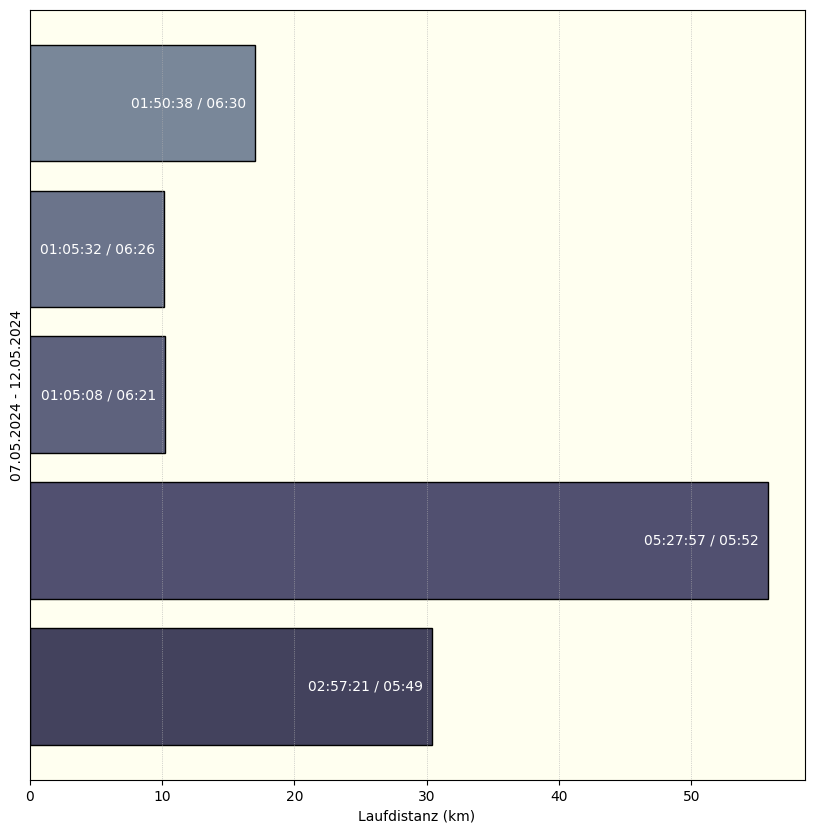

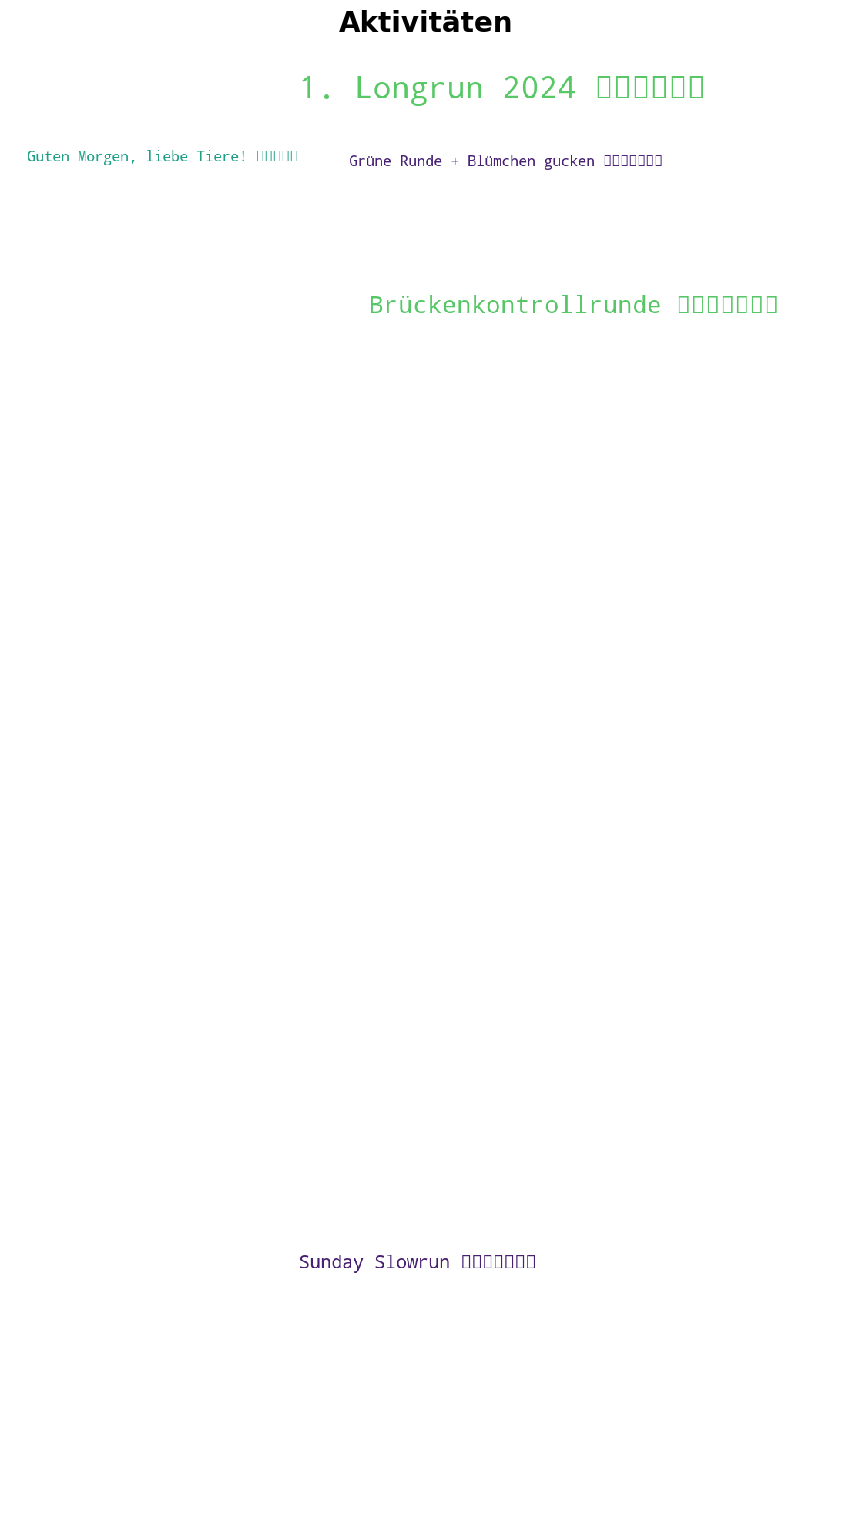

Video erfolgreich erzeugt!

Laufzeit gesamt: 3.51 Sekunden


In [107]:

if __name__ == "__main__":
    try:
        # Programmlauf starten
        internal_id = datetime.now().strftime("%Y%m%d%H%M%S")
        start_time = datetime.now() # Zeitstempel für Laufzeitberechnung
        start_time_fomatted = start_time.strftime("%d.%m.%Y - %H:%M:%S")
        print(f"Startzeit: {start_time_fomatted}")
        log_step(f"Programmstart: {start_time_fomatted}", internal_id, db_filename)

        args = parse_arguments()
        main(args.run_mode, args.sportid, args.background_sound, args.start_date_string, args.end_date_string, args.max_download_frequency)

        print('Video erfolgreich erzeugt!')
        print('')
        end_time = datetime.now() # Ende Laufzeit
        end_time_formatted = end_time.strftime("%d.%m.%Y - %H:%M:%S")
        duration = end_time - start_time
        seconds = duration.total_seconds()
        log_step(f"Ende Laufzeit === Laufzeit gesamt: {seconds:.2f} Sekunden", internal_id, db_filename)
        print(f"Laufzeit gesamt: {seconds:.2f} Sekunden")

    except Exception as e:
        # Bei einem Fehler Protokollierung und Fehlerbehandlung
        end_time = datetime.now() # Ende Laufzeit
        end_time_formatted = end_time.strftime("%d.%m.%Y - %H:%M:%S")
        log_step(f"Fehler aufgetreten: {str(e)} - Abbruch!", internal_id, db_filename)
        sys.exit(1)  # Programm beenden

    finally:
        # Wenn das Programm erfolgreich ausgeführt wurde oder abgebrochen wurde,
        # Protokoll abschließen und speichern. 
        log_step(f"Programmende: {end_time_formatted}", internal_id, db_filename)
        internal_id = None

if __name__ == "__savereqs__":
    try:
        # Programmlauf starten
        internal_id = datetime.now().strftime("%Y%m%d%H%M%S")
        start_time = datetime.now() # Zeitstempel für Laufzeitberechnung
        start_time_fomatted = start_time.strftime("%d.%m.%Y - %H:%M:%S")
        log_step(f"Nur Requirements in die Datenbank schreiben! {start_time_fomatted}", internal_id, db_filename)
        save_reqs(db_filename)
    except Exception as e:
        # Bei einem Fehler Protokollierung und Fehlerbehandlung
        end_time = datetime.now() # Ende Laufzeit
        end_time_formatted = end_time.strftime("%d.%m.%Y - %H:%M:%S")
        log_step(f"Fehler aufgetreten: {str(e)} - Abbruch!", internal_id, db_filename)
        sys.exit(1)  # Programm beenden
    finally:
        internal_id = None

if __name__ == "__installreqs__":
    try:
        # Programmlauf starten
        internal_id = datetime.now().strftime("%Y%m%d%H%M%S")
        start_time = datetime.now() # Zeitstempel für Laufzeitberechnung
        start_time_fomatted = start_time.strftime("%d.%m.%Y - %H:%M:%S")
        log_step(f"Nur Requirements installieren! {start_time_fomatted}", internal_id, db_filename)
        install_reqs(db_filename)
    except Exception as e:
        # Bei einem Fehler Protokollierung und Fehlerbehandlung
        end_time = datetime.now() # Ende Laufzeit
        end_time_formatted = end_time.strftime("%d.%m.%Y - %H:%M:%S")
        log_step(f"Fehler aufgetreten: {str(e)} - Abbruch!", internal_id, db_filename)
        sys.exit(1)  # Programm beenden
    finally:
        internal_id = None